In [1]:
using BenchmarkTools
using Revise
using Distributions
using DataFrames
using Plots
using LaTeXStrings

In [2]:
includet("../GameAnalysis.jl")

In [3]:
function trivial_LogProbabilities_game(num_players, num_actions)
    num_configs = multinomial(num_players-1, num_actions-1)
    config_table = Array{Int64}(undef, num_configs, num_actions)
    repeat_table = Array{Float64}(undef, num_configs)
    log_payoffs = Array{Float64}(undef, num_configs, num_actions)
    log_payoffs .= log.(collect(1:num_actions)')
    for (c,config) in enumerate(CwR(1:num_actions, num_players-1))
        prof = counts(config, 1:num_actions)
        config_table[c,:] = prof
        repeat_table[c] = logmultinomial(prof...)
    end
    LogProbabilities(num_players, num_actions, config_table,
                     log_payoffs .+ repeat_table, 1, 1)
end

function trivial_CPU_32bit_game(num_players, num_actions)
    num_configs = multinomial(num_players-1, num_actions-1)
    config_table = zeros(Float32, num_configs, num_actions)
    repeat_table = Array{Float64}(undef, num_configs)
    log_payoffs = Array{Float64}(undef, num_configs, num_actions)
    log_payoffs .= log.(collect(1:num_actions)')
    for (c,config) in enumerate(CwR(1:num_actions, num_players-1))
        prof = counts(config, 1:num_actions)
        config_table[c,:] = prof
        repeat_table[c] = logmultinomial(prof...)
    end
    CPU_32bit(num_players, num_actions, config_table,
                log_payoffs .+ repeat_table, 1, 1)
end

trivial_CPU_32bit_game (generic function with 1 method)

In [4]:
function game_size_64(players, strategies)
    configs = multinomial(players-1, strategies-1)
    size = configs * strategies * sizeof(Int64) # config_table
    size += configs * strategies * sizeof(Float64) # payoff_table
    size += 2 * sizeof(Int64) # num_actions, num_players
    size += 2 * strategies * sizeof(Float32) # offsets, scales
    return size + 192 # it seems there's another 192 Bytes of metadata
end

# Note: this is the size in RAM of CPU_32bit, which *approximates* the size in GPU memory of GPUArrays.
function game_size_32(players, strategies)
    configs = multinomial(players-1, strategies-1)
    size = configs * strategies * sizeof(Float32) # config_table
    size += configs * strategies * sizeof(Float32) # payoff_table
    size += 2 * sizeof(Int64) # num_actions, num_players
    size += 2 * strategies * sizeof(Float32) # offsets, scales
    return size + 192 # it seems there's another 192 Bytes of metadata
end

function tables_size(players, strategies, bits)
    return multinomial(players-1, strategies-1) * strategies * bits ÷ 4
end

tables_size (generic function with 1 method)

In [10]:
size_data_64 = DataFrame(players=Int[], strategies=Int[], predicted=Int[], actual=Int[], GiB=Float64[])
for s=2:8
    display(s)
    for p=20:40
        g = trivial_LogProbabilities_game(p,s)
        predicted = game_size_64(p,s)
        actual = Base.summarysize(g)
        push!(size_data_64, (p,s,predicted,actual,actual/2^30))
        if actual > 2^30
            println("Larger than 1GiB at:")
            println("s=",s, " p=",p, " size=",round(actual/2^30, digits=2), "GiB")
            break
        end
    end
end
size_data_64

2

3

4

5

6

7

8

Larger than 1GiB at:
s=8 p=31 size=1.23GiB


,players,strategies,predicted,actual,GiB
,Int64,Int64,Int64,Int64,Float64
1,20,2,864,768,7.15256e-7
2,21,2,896,800,7.45058e-7
3,22,2,928,832,7.7486e-7
4,23,2,960,864,8.04663e-7
5,24,2,992,896,8.34465e-7
6,25,2,1024,928,8.64267e-7
7,26,2,1056,960,8.9407e-7
8,27,2,1088,992,9.23872e-7
9,28,2,1120,1024,9.53674e-7


In [6]:
size_data_32 = DataFrame(players=Int[], strategies=Int[], predicted=Int[], actual=Int[], GiB=Float64[])
for s=2:8
    display(s)
    for p=20:40
        #g = trivial_CPU_32bit_game(p,s)
        predicted = game_size_32(p,s)
        actual = 0#Base.summarysize(g)
        push!(size_data_32, (p,s,predicted,actual,actual/2^30))
        if actual > 2^30
            println("Larger than 1GiB at:")
            println("s=",s, " p=",p, " size=",round(actual/2^30, digits=2), "GiB")
            break
        end
    end
end
size_data_32

2

3

4

5

6

7

8

,players,strategies,predicted,actual,GiB
,Int64,Int64,Int64,Int64,Float64
1,20,2,544,0,0.0
2,21,2,560,0,0.0
3,22,2,576,0,0.0
4,23,2,592,0,0.0
5,24,2,608,0,0.0
6,25,2,624,0,0.0
7,26,2,640,0,0.0
8,27,2,656,0,0.0
9,28,2,672,0,0.0


In [15]:
print("All 64-bit predictions correct? ")
println(all(size_data_64[:,"predicted"] .== size_data_64[:,"actual"]))
print("All 32-bit predictions correct? ")
println(all(size_data_32[:,"predicted"] .== size_data_32[:,"actual"]))

All 64-bit predictions correct? false
All 32-bit predictions correct? false


In [16]:
game_size_64(20,10) / tables_size(20,10,64)

1.0000002606089562

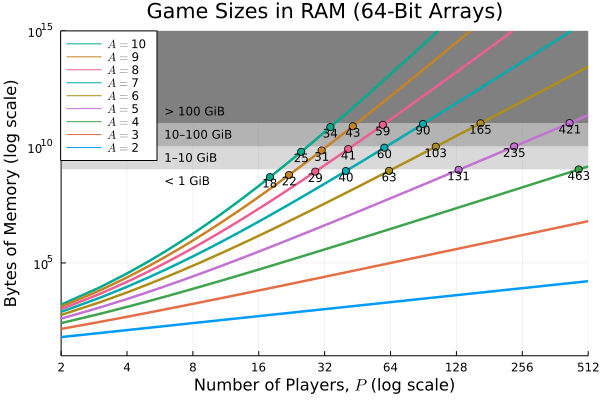

In [14]:
max_players = 512
players_range = collect(2:max_players)
sizes_64 = Dict()
plot(xaxis=:log, yaxis=:log, ylim=(1e1,1e15), xlim=(2,max_players), legend=(0.088, 0.96), legend_font_pointsize=8)
plot!([2;max_players],[100*2^30,100*2^30],fillrange=[2^50,2^50], color=nothing, fillcolor=:gray, fillalpha=1.0, label="")
plot!([2;max_players],[10*2^30,10*2^30],fillrange=[100*2^30,100*2^30], color=nothing, fillcolor=:gray, fillalpha=0.6, label="")
plot!([2;max_players],[2^30,2^30],fillrange=[10*2^30,10*2^30], color=nothing, fillcolor=:gray, fillalpha=0.3, label="")
scatter!([6;6;6;6],[3.5e8;3.5e9;3.5e10;3.5e11],series_annotations=
         [("< 1 GiB", :left, 8),("1–10 GiB", :left, 8),("10–100 GiB", :left, 8),("> 100 GiB", :left, 8)],
         markeralpha=0, label="")
for s in 10:-1:2
    sizes_64[s] = [tables_size(p,s,64) for p in players_range]
    above_1G = findfirst(sizes_64[s] .> 2^30)
    above_10G = findfirst(sizes_64[s] .> 10*2^30)
    above_100G = findfirst(sizes_64[s] .> 100*2^30)
    plot!(players_range, sizes_64[s], label=L"$A =$" * string(s), seriescolor=s-1, linewidth=2.5)
end
for s in 10:-1:2
    above_1G = findfirst(sizes_64[s] .> 2^30)
    above_10G = findfirst(sizes_64[s] .> 10*2^30)
    above_100G = findfirst(sizes_64[s] .> 100*2^30)
    if !isnothing(above_1G)
        scatter!([above_1G-1], [sizes_64[s][above_1G-2]], series_annotations=[(above_1G-1, :top, 8)], seriescolor=s-1, label="")
    end
    if !isnothing(above_10G)
        scatter!([above_10G-1], [sizes_64[s][above_10G-2]], series_annotations=[(above_10G-1, :top, 8)], seriescolor=s-1, label="")
    end
    if !isnothing(above_100G)
        scatter!([above_100G-1], [sizes_64[s][above_100G-2]], series_annotations=[(above_100G-1, :top, 8)], seriescolor=s-1, label="")
    end
end
plot!(xlabel=L"Number of Players, $P$ (log scale)", ylabel="Bytes of Memory (log scale)", title="Game Sizes in RAM (64-Bit Arrays)")
plot!(xticks=([2^i for i=1:9], [2^i for i=1:9]))

# savefig("../figures/log_mem_limit_64.png")


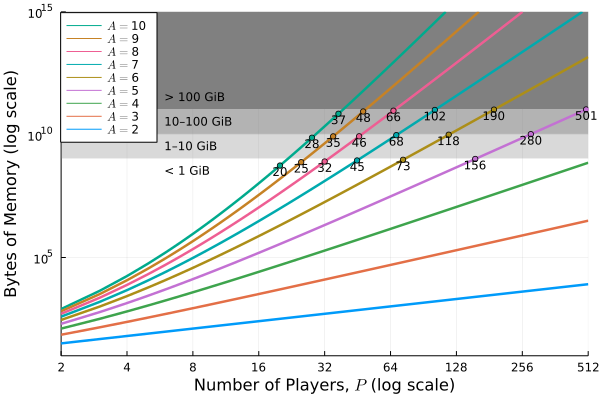

In [15]:
max_players = 512
players_range = collect(2:max_players)
sizes_32 = Dict()
plot(xaxis=:log, yaxis=:log, ylim=(1e1,1e15), xlim=(2,max_players), legend=(0.088, 0.96), legend_font_pointsize=8)
plot!([1;max_players],[100*2^30,100*2^30],fillrange=[2^50,2^50], color=nothing, fillcolor=:gray, fillalpha=1.0, label="")
plot!([1;max_players],[10*2^30,10*2^30],fillrange=[100*2^30,100*2^30], color=nothing, fillcolor=:gray, fillalpha=0.6, label="")
plot!([1;max_players],[2^30,2^30],fillrange=[10*2^30,10*2^30], color=nothing, fillcolor=:gray, fillalpha=0.3, label="")
scatter!([6;6;6;6],[3.5e8;3.5e9;3.5e10;3.5e11],series_annotations=
         [("< 1 GiB", :left, 8),("1–10 GiB", :left, 8),("10–100 GiB", :left, 8),("> 100 GiB", :left, 8)],
         markeralpha=0, label="")
for s in 10:-1:2
    sizes_32[s] = [tables_size(p,s,32) for p in players_range]
    above_1G = findfirst(sizes_32[s] .> 2^30)
    above_10G = findfirst(sizes_32[s] .> 10*2^30)
    above_100G = findfirst(sizes_32[s] .> 100*2^30)
    plot!(players_range, sizes_32[s], label=L"$A =$" * string(s), seriescolor=s-1, linewidth=2.5)
end
for s in 10:-1:2
    above_1G = findfirst(sizes_32[s] .> 2^30)
    above_10G = findfirst(sizes_32[s] .> 10*2^30)
    above_100G = findfirst(sizes_32[s] .> 100*2^30)
    if !isnothing(above_1G)
        scatter!([above_1G-1], [sizes_32[s][above_1G-2]], series_annotations=[(above_1G-1, :top, 8)], seriescolor=s-1, label="", markersize=3)
    end
    if !isnothing(above_10G)
        scatter!([above_10G-1], [sizes_32[s][above_10G-2]], series_annotations=[(above_10G-1, :top, 8)], seriescolor=s-1, label="", markersize=3)
    end
    if !isnothing(above_100G)
        scatter!([above_100G-1], [sizes_32[s][above_100G-2]], series_annotations=[(above_100G-1, :top, 8)], seriescolor=s-1, label="", markersize=3)
    end
end
plot!(xlabel=L"Number of Players, $P$ (log scale)", ylabel="Bytes of Memory (log scale)")#, title="Game Sizes on GPU (32-Bit Arrays)")
plot!(xticks=([2^i for i=1:9], [2^i for i=1:9]))

# savefig("../figures/log_mem_limit_32.png")
